# Data & Feature Engineering for Equity VaR Backtesting

 All risk models depend on clean returns and volatility estimates.  

 This notebook builds the foundational dataset used for all downstream GBM, Jump Diffusion, and Markov regime backtests.


In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
from pathlib import Path

PROJECT_NAME = "equity_var_backtesting"
BASE = Path("/content/drive/MyDrive") / PROJECT_NAME

DIRS = {
    "data_raw": BASE / "data" / "raw",
    "data_processed": BASE / "data" / "processed",
    "figures": BASE / "outputs" / "figures"
}

for p in DIRS.values():
    p.mkdir(parents=True, exist_ok=True)

BASE


PosixPath('/content/drive/MyDrive/equity_var_backtesting')

In [3]:
!pip -q install yfinance pandas numpy pyarrow matplotlib


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

pd.set_option("display.max_columns", 50)
plt.rcParams["figure.figsize"] = (12, 5)

TICKERS = ["SPY", "AAPL", "MSFT", "JPM", "XOM", "TSLA"]
START = "2015-01-01"
END   = "2025-12-20"

TRADING_DAYS = 252
VOL_WINDOW = 20


In [5]:
raw = yf.download(
    tickers=TICKERS,
    start=START,
    end=END,
    auto_adjust=True,
    progress=False,
    group_by="column"
)

px = raw["Close"].copy()
px = px.dropna(how="all")

px.tail()


Ticker,AAPL,JPM,MSFT,SPY,TSLA,XOM
Date,,,,,,
2025-12-15,274.109985,320.019989,474.820007,678.724426,475.309998,117.760002
2025-12-16,274.609985,315.549988,476.390015,676.869934,489.880005,114.680000
2025-12-17,271.839996,314.980011,476.119995,669.421936,467.260010,117.410004
2025-12-18,272.190002,313.000000,483.980011,674.476929,483.369995,116.540001
2025-12-19,273.670013,317.209991,485.920013,680.590027,481.200012,116.690002


In [6]:
raw_path = DIRS["data_raw"] / "adjusted_prices.csv"
px.reset_index().to_csv(raw_path, index=False)

print("Saved raw prices to:", raw_path)


Saved raw prices to: /content/drive/MyDrive/equity_var_backtesting/data/raw/adjusted_prices.csv


In [7]:
#Compute Log returns
logret = np.log(px / px.shift(1))
logret = logret.dropna(how="all")

logret.tail()


Ticker,AAPL,JPM,MSFT,SPY,TSLA,XOM
Date,,,,,,
2025-12-15,-0.015098,0.004698,-0.007783,-0.001512,0.035004,-0.008961
2025-12-16,0.001822,-0.014066,0.003301,-0.002736,0.030193,-0.026503
2025-12-17,-0.010138,-0.001808,-0.000567,-0.011065,-0.047275,0.023526
2025-12-18,0.001287,-0.006306,0.016374,0.007523,0.033897,-0.007438
2025-12-19,0.005423,0.013361,0.004000,0.009023,-0.004499,0.001286


In [8]:
#Compute realized volatility (20-day)
realized_vol = logret.rolling(VOL_WINDOW).std() * np.sqrt(TRADING_DAYS)
realized_vol.tail()


Ticker,AAPL,JPM,MSFT,SPY,TSLA,XOM
Date,,,,,,
2025-12-15,0.162420,0.273087,0.226621,0.120561,0.364760,0.168792
2025-12-16,0.146725,0.275499,0.227769,0.115450,0.373045,0.187153
2025-12-17,0.152238,0.275163,0.208938,0.118631,0.412682,0.202384
2025-12-18,0.151736,0.274060,0.213392,0.120561,0.423051,0.197752
2025-12-19,0.148467,0.268607,0.205308,0.106879,0.410511,0.197608


In [9]:
#Building long-format feature table
df_prices = px.stack().rename("price").reset_index()
df_prices.columns = ["date", "ticker", "price"]

df_ret = logret.stack().rename("log_return").reset_index()
df_ret.columns = ["date", "ticker", "log_return"]

df_vol = realized_vol.stack().rename("realized_vol_20d").reset_index()
df_vol.columns = ["date", "ticker", "realized_vol_20d"]

df = (
    df_prices
    .merge(df_ret, on=["date", "ticker"], how="left")
    .merge(df_vol, on=["date", "ticker"], how="left")
    .sort_values(["ticker", "date"])
)

df.head()


,date,ticker,price,log_return,realized_vol_20d
0,2015-01-02,AAPL,24.237551,NaN,NaN
6,2015-01-05,AAPL,23.554741,-0.028576,NaN
12,2015-01-06,AAPL,23.556965,0.000094,NaN
18,2015-01-07,AAPL,23.887274,0.013924,NaN
24,2015-01-08,AAPL,24.805077,0.037702,NaN


In [10]:
#Checking Quality
summary = df.groupby("ticker").agg(
    start_date=("date", "min"),
    end_date=("date", "max"),
    n_obs=("price", "count"),
    ann_return_approx=("log_return", lambda x: x.mean() * TRADING_DAYS),
    ann_vol_approx=("log_return", lambda x: x.std() * np.sqrt(TRADING_DAYS))
)

display(summary.round(4))


,start_date,end_date,n_obs,ann_return_approx,ann_vol_approx
ticker,,,,,
AAPL,2015-01-02,2025-12-19,2759,0.2215,0.2885
JPM,2015-01-02,2025-12-19,2759,0.1750,0.2713
MSFT,2015-01-02,2025-12-19,2759,0.2285,0.2689
SPY,2015-01-02,2025-12-19,2759,0.1264,0.1785
TSLA,2015-01-02,2025-12-19,2759,0.3192,0.5764
XOM,2015-01-02,2025-12-19,2759,0.0640,0.2746


In [11]:
processed_path = DIRS["data_processed"] / "prices_returns.parquet"
df.to_parquet(processed_path, index=False)

print("Saved processed features to:", processed_path)


Saved processed features to: /content/drive/MyDrive/equity_var_backtesting/data/processed/prices_returns.parquet


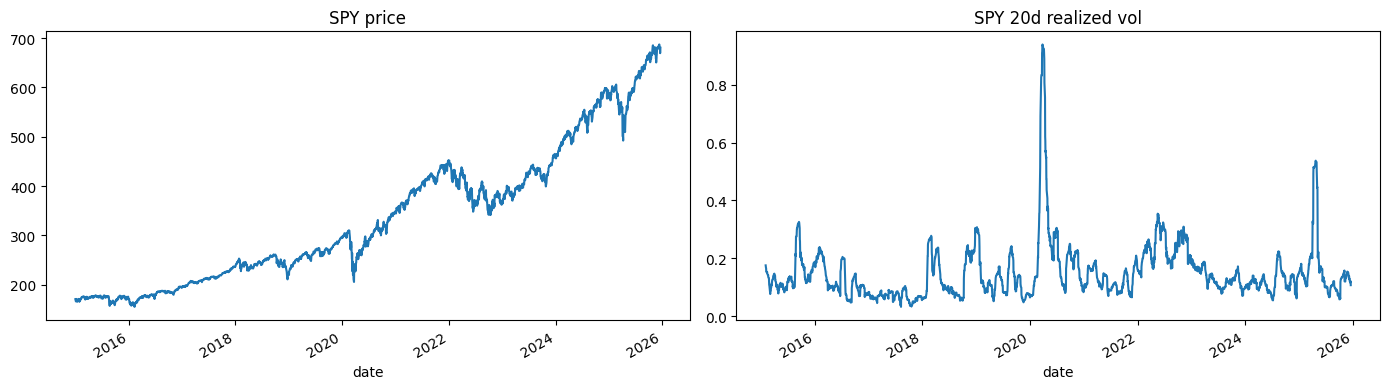

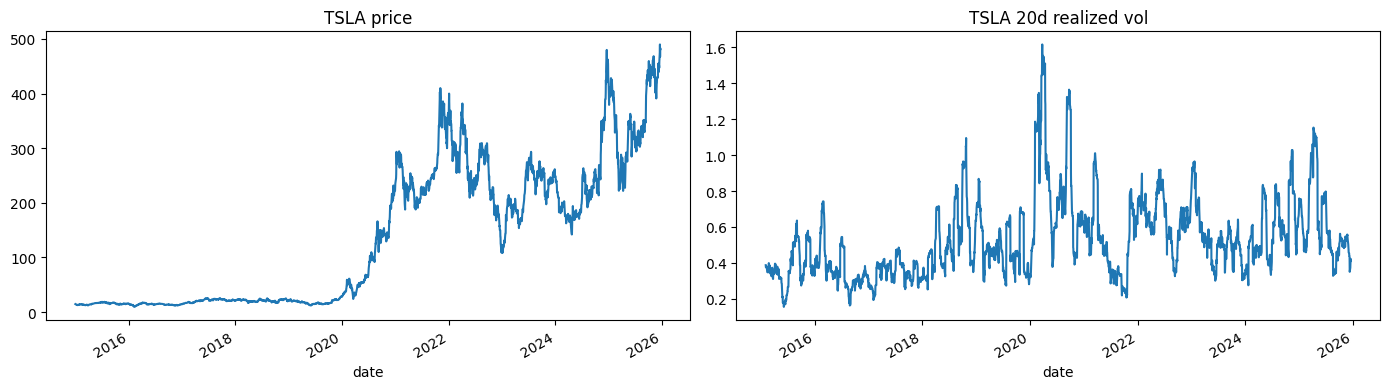

In [12]:
#Plots
def plot_price_and_vol(ticker):
    sub = df[df["ticker"] == ticker].set_index("date")
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    sub["price"].plot(ax=ax[0], title=f"{ticker} price")
    sub["realized_vol_20d"].plot(ax=ax[1], title=f"{ticker} 20d realized vol")
    plt.tight_layout()
    plt.show()

plot_price_and_vol("SPY")
plot_price_and_vol("TSLA")
